- get rain data and visualise for overview <font color='orange'>&#9728;</font>
- cut and split data to reasonable train, val, test sets <font color='orange'>&#9728;</font>
- set up first generator and discriminator and overfit, play around with it, get first results (_November/December_)
- train on small training set and improve losses, accuracy, results (_December_)
- experiment with temporal discriminator (_December/January_)
- experiment with wind data (_January_)

## Imports and settings

In [1]:
import src
import keras.backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4128813581588735197
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [4]:
images = np.load(sys.path[0]+"/5_minute.npy").item()

In [5]:
#low_res_train = images["low_res_train"]
#low_res_xval = images["low_res_xval"]
#low_res_test = images["low_res_test"]
#overfit = np.reshape(images['images'],np.shape(images['images'])+(1,))
train = np.reshape(images["train"],np.shape(images["train"])+(1,))
xval = np.reshape(images["xval"],np.shape(images["xval"])+(1,))
test = np.reshape(images["test"],np.shape(images["test"])+(1,))
print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


In [6]:
unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))

(6000, 64, 64, 1) 
 (6000, 64, 64, 1) 
 (2000, 64, 64, 1) 
 (6000, 64, 64, 1)


In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## U-net

In [7]:
model2=keras.Sequential()

init = keras.layers.Input(shape=(64,64,1))
ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
Lr1 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
#64
ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
Lr2 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
#32
ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
Lr3 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
#16
ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
Lr4 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
#8
ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
Lr5 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
#4

UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
#8
merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
Lr6 = keras.layers.LeakyReLU(alpha=0.0)(Conv1)
#8
UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
#16
merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
Lr7  = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
#16
UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

#32
Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
Lr8  = keras.layers.LeakyReLU(alpha=0.0)(Conv3)

UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
#64
Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

Conv5   = keras.layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)

model2 = keras.models.Model(inputs=init, outputs=Conv5)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    40          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   528         leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [8]:
#train the model
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss(["l2", "l1", "l33"]), metrics=[src.relative_error_tensor]) 
model2.fit(unet_train[:10],
          unet_truth[:10],
          batch_size = 10,
          epochs=2,
          validation_data=(unet_val[:10],unet_val_truth[:10]),
          shuffle = False)

***Using L1 + L2 loss.***
Tensor("metrics/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_10_target:0", shape=(?, ?, ?, ?), dtype=float32)
Train on 10 samples, validate on 10 samples
Epoch 1/2
10/10 [==============================] - 1s 150ms/step - loss: 0.5965 - relative_error_tensor: 1.0645 - val_loss: 0.7214 - val_relative_error_tensor: 1.0240
Epoch 2/2
10/10 [==============================] - 0s 47ms/step - loss: 0.5756 - relative_error_tensor: 1.0359 - val_loss: 0.6979 - val_relative_error_tensor: 1.0003


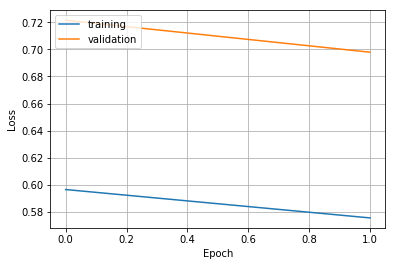

In [9]:
hist = model2.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [10]:
#test
predictions = model2.predict(unet_test, batch_size=100)
truth       = unet_test_truth
truth.shape

(2000, 64, 64, 1)

In [11]:
args = src.arg_getter(truth, predictions)
args[-1]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:256: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:256: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


615

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:256: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:256: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


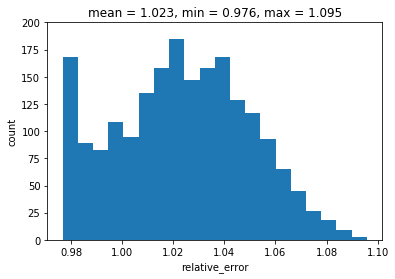

In [12]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions,metric="relative_error")

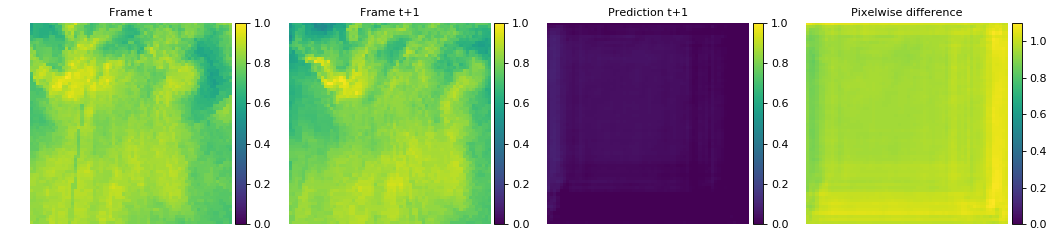

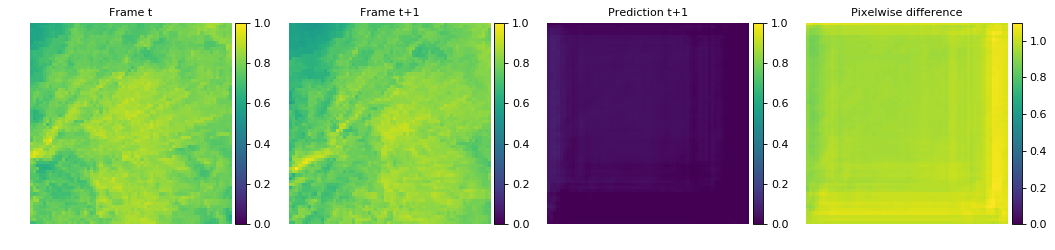

In [13]:
src.result_plotter(args[0:2], (unet_test[:,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))